1. Cargar y limpiar datos

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Cargar el dataset
file_path = './../data/linkedin_profiles_v9.csv'  # Cambia esto por la ruta correcta de tu archivo
df = pd.read_csv(file_path)

# Filtrar perfiles que tienen empleo actual en función de al menos uno de los dos campos
df['employed'] = df['current_company:company_id'].notna() | df['current_company:name'].notna()

# Contar el número de filas antes de eliminar
rows_before = df.shape[0]

# Eliminar filas donde 'experience' es nulo o vacío y hay empleo actual
df = df[~((df['experience'].isna() | (df['experience'].str.strip() == '')) & df['employed'])]

# Filtrar filas que contienen palabras relacionadas con retiro o jubilación en la columna 'position'
keywords = ['retired', 'retirement', 'jubilado', 'retiro', 'jubilation', 'pension', 'pensionado', 'pensioen', 
            'rentner', 'pensione', 'retirado', '退職', '引退', 'пенсия', '退休', '연금', 'pesentado', 'retraité']

# Crear un patrón regex para buscar todas las palabras clave
pattern = '|'.join(keywords)

# Eliminar filas donde 'position' contiene palabras relacionadas con retiro o jubilación
df = df[~df['position'].str.contains(pattern, case=False, na=False)]

# Contar el número de filas después de eliminar
rows_after = df.shape[0]

# Calcular cuántas filas fueron eliminadas
rows_deleted = rows_before - rows_after

print(f"Número de filas eliminadas: {rows_deleted}")
print(f"Número de filas restantes: {rows_after}")

# Convertir la columna 'employed' a entero (1 si tiene empleo, 0 si no)
df['employed'] = df['employed'].astype(int)

Número de filas eliminadas: 10
Número de filas restantes: 990


In [21]:
# Total profiles in the dataset
total_profiles = len(df)

# Define unemployment condition based on specified fields
unemployed_condition = (
    (df['current_company:company_id'].isna() | (df['current_company:company_id'] == '')) &
    (df['current_company:name'].isna() | (df['current_company:name'] == ''))
)

# Calculate number of employed and unemployed profiles
unemployed = df[unemployed_condition].shape[0]
employed = total_profiles - unemployed

# Calculate percentages
percentage_employed = (employed / total_profiles) * 100
percentage_unemployed = (unemployed / total_profiles) * 100

# Calculate education and certifications count
df['education_count'] = df['education'].apply(lambda x: len(eval(x)) if pd.notnull(x) and x.startswith('[') else 0)
df['certifications_count'] = df['certifications'].apply(lambda x: len(eval(x)) if pd.notnull(x) and x.startswith('[') else 0)

# Profiles with educational details
profiles_with_education = df['education_count'].gt(0).sum()
percentage_with_education = (profiles_with_education / total_profiles) * 100

# Profiles with certifications
profiles_with_certifications = df['certifications_count'].gt(0).sum()
percentage_with_certifications = (profiles_with_certifications / total_profiles) * 100

# Display the results
print(f"Employed: {employed} ({percentage_employed:.2f}%)")
print(f"Unemployed: {unemployed} ({percentage_unemployed:.2f}%)")
print(f"Profiles with Education: {profiles_with_education} ({percentage_with_education:.2f}%)")
print(f"Profiles with Certifications: {profiles_with_certifications} ({percentage_with_certifications:.2f}%)")

Employed: 825 (83.33%)
Unemployed: 165 (16.67%)
Profiles with Education: 718 (72.53%)
Profiles with Certifications: 184 (18.59%)


2. Extracción de características

In [22]:
from datetime import datetime
from dateutil import parser
import json

def count_entries(column):
    try:
        return len(eval(column)) if pd.notnull(column) and column.startswith('[') else 0
    except:
        return 0

# Aplicar funciones de extracción
df['education_count'] = df['education'].apply(count_entries)
df['certifications_count'] = df['certifications'].apply(count_entries)
df['languages_count'] = df['languages'].apply(count_entries)
df['volunteer_experience_count'] = df['volunteer_experience'].apply(count_entries)
df['courses_count'] = df['сourses'].apply(count_entries)

# Lista de términos que representan la actualidad en varios idiomas
terms_for_present = [
    'present', 'actualidad', 'aujourd’hui', 'heden', 'nu', 'momento', 'heute',
    'obecnie', 'kasalukuyan', 'o momento', 'aujourd’hui', 'heden', 'oggi', 
    'today', 'aktuell', 'heden', 'aujourd’hui', 'nu', 'nu', 'nu', 'aujourd’hui'
]

# Función para convertir fechas a un formato estandarizado
def parse_date(date_str):
    if not date_str or any(term in date_str.lower() for term in terms_for_present):
        return datetime.now()  # Tratar términos de actualidad como la fecha actual

    # Intentar con diferentes formatos manualmente si parser no funciona
    date_formats = [
        '%b %Y',  # Ejemplo: Jan 2020
        '%Y',     # Ejemplo: 2020
    ]

    # Tratar de parsear usando diferentes formatos
    for fmt in date_formats:
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue

    # Tratar con parser si los formatos anteriores fallan
    try:
        return parser.parse(date_str, default=datetime(1, 1, 1), fuzzy=True)
    except (ValueError, TypeError):
        print(f"Error al parsear la fecha '{date_str}': Unknown string format")
        return None

# Función mejorada para calcular años de experiencia evitando la superposición de fechas
def extract_experience_years_from_json(experience):
    try:
        periods = []
        experience_data = json.loads(experience)

        for job in experience_data:
            positions = job.get('positions', [job])  # Si no hay posiciones, usar el trabajo mismo
            for position in positions:
                start_date_str = position.get('start_date', None)
                end_date_str = position.get('end_date', None)

                start_date = parse_date(start_date_str)
                end_date = parse_date(end_date_str) if end_date_str else datetime.now()

                if start_date and end_date:
                    periods.append((start_date, end_date))

        if not periods:
            return 0

        # Consolidar períodos para evitar la superposición
        periods = sorted(periods, key=lambda x: x[0])
        consolidated_periods = []
        current_start, current_end = periods[0]

        for start, end in periods[1:]:
            if start <= current_end:  # Si los períodos se solapan, extender el período actual
                current_end = max(current_end, end)
            else:  # Si no se solapan, añadir el período consolidado y empezar un nuevo período
                consolidated_periods.append((current_start, current_end))
                current_start, current_end = start, end

        consolidated_periods.append((current_start, current_end))  # Añadir el último período

        # Calcular la experiencia total en años y meses
        total_months = sum((end.year - start.year) * 12 + (end.month - start.month) for start, end in consolidated_periods)
        total_years = total_months // 12
        return total_years

    except Exception as e:
        print(f"Error procesando la experiencia: {e}")
        return 0

# Aplicar la función mejorada de experiencia
df['experience_years'] = df['experience'].apply(lambda x: extract_experience_years_from_json(x) if isinstance(x, str) else 0)
df.head()

,timestamp,id,name,city,country_code,region,current_company:company_id,current_company:name,position,following,...,recommendations_count,volunteer_experience,сourses,employed,education_count,certifications_count,languages_count,volunteer_experience_count,courses_count,experience_years
0,2023-01-10,catherinemcilkenny,"Catherine Fitzpatrick (McIlkenny), B.A",Canada,CA,NaN,NaN,NaN,Snr Business Analyst at Emploi et Développemen...,NaN,...,NaN,NaN,NaN,0,5,0,0,0,0,0
1,2022-12-17,margot-bon-51a04624,Margot Bon,"The Randstad, Netherlands",NL,EU,gemeente-utrecht,Gemeente Utrecht,Communicatieadviseur Corporate & Strategie Gem...,NaN,...,2.0,"[{""cause"":"""",""duration"":""Sep 2010 Jul 2020 9 y...",NaN,1,6,1,4,3,0,28
2,2023-05-17,mike-dean-8509a193,Mike Dean,"England, United Kingdom",UK,NaN,network-rail,Network Rail,Network Data Manager at Network Rail,NaN,...,NaN,NaN,NaN,1,1,0,0,0,0,32
3,2022-05-29,giovanna-panarella-99a0a4167,Giovanna Panarella,"Avellino, Campania, Italy",IT,EU,NaN,Freelance,Architetto (Freelance),500.0,...,NaN,"[{""cause"":""Arts and Culture"",""duration"":""Jan 2...",NaN,1,5,0,0,1,0,6
4,2022-12-06,steve-latimer-3364327,Steve Latimer,"Ontario, Canada",CA,NaN,mid-range-computer-group-inc.,Mid-Range Computer Group Inc.,Senior Account Executive at Mid-Range Computer...,NaN,...,1.0,NaN,NaN,1,2,43,0,0,0,31


3. Preparación de Datos para Entrenamiento

In [23]:
# Preparar las características y etiquetas
features = ['education_count', 'certifications_count', 'languages_count', 
            'volunteer_experience_count', 'courses_count', 'experience_years']
X = df[features].fillna(0)
y = df['employed']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

4. Entrenamiento y Evaluación de Múltiples Modelos (XGBoost)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters for XGBoost: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 15, 'n_estimators': 200, 'subsample': 0.6}


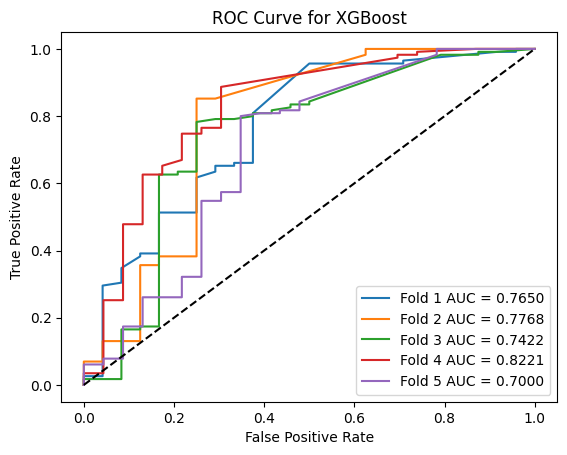

Average Precision for class 0: 0.4301
Average Precision for class 1: 0.9180
Average Weighted Precision: 0.8349
Average Recall for class 0: 0.6438
Average Recall for class 1: 0.8209
Average Weighted Recall: 0.7908
Average F1-Score for class 0: 0.5147
Average F1-Score for class 1: 0.8664
Average Weighted F1-Score: 0.8066
Average AUC-ROC: 0.7612
Averaged Confusion Matrix:
[[15.2  8.4]
 [20.6 94.4]]


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt

# Apply SMOTE to balance classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Configure the models and parameters for GridSearch
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search_xgb = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=param_grid_xgb,
    scoring='f1_weighted',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Execute the Grid Search
grid_search_xgb.fit(X_train_resampled, y_train_resampled)
print(f"Best parameters for XGBoost: {grid_search_xgb.best_params_}")

# Evaluate the optimized model with StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the XGBoost model with the best hyperparameters
xgb_model = XGBClassifier(**grid_search_xgb.best_params_, random_state=42)

# Convert y_train to numpy array to avoid indexing issues
y_train_array = np.array(y_train)

# Initialize lists to store metrics for each fold
precision_scores = {'0': [], '1': [], 'weighted': []}
recall_scores = {'0': [], '1': [], 'weighted': []}
f1_scores = {'0': [], '1': [], 'weighted': []}
confusion_matrices = []
roc_aucs = []

# Perform stratified cross-validation
for train_index, test_index in skf.split(X_train_scaled, y_train_array):
    # Split the data into training and validation for each fold
    X_fold_train, X_fold_val = X_train_scaled[train_index], X_train_scaled[test_index]
    y_fold_train, y_fold_val = y_train_array[train_index], y_train_array[test_index]

    # Apply SMOTE to each fold to balance the classes
    X_fold_resampled, y_fold_resampled = smote.fit_resample(X_fold_train, y_fold_train)

    # Train the model on the current fold
    xgb_model.fit(X_fold_resampled, y_fold_resampled)
    y_fold_pred = xgb_model.predict(X_fold_val)
    y_fold_probs = xgb_model.predict_proba(X_fold_val)[:, 1]  # Get probabilities for class 1

    # Calculate performance metrics
    report = classification_report(y_fold_val, y_fold_pred, output_dict=True)
    
    # Store metrics for each class and weighted average
    precision_scores['0'].append(report['0']['precision'])
    precision_scores['1'].append(report['1']['precision'])
    precision_scores['weighted'].append(report['weighted avg']['precision'])
    
    recall_scores['0'].append(report['0']['recall'])
    recall_scores['1'].append(report['1']['recall'])
    recall_scores['weighted'].append(report['weighted avg']['recall'])
    
    f1_scores['0'].append(report['0']['f1-score'])
    f1_scores['1'].append(report['1']['f1-score'])
    f1_scores['weighted'].append(report['weighted avg']['f1-score'])
    
    confusion_matrices.append(confusion_matrix(y_fold_val, y_fold_pred))
    
    # Calculate AUC-ROC for the current fold
    roc_auc = roc_auc_score(y_fold_val, y_fold_probs)
    roc_aucs.append(roc_auc)
    
    # Plot ROC curve for the current fold
    fpr, tpr, _ = roc_curve(y_fold_val, y_fold_probs)
    plt.plot(fpr, tpr, label=f'Fold {len(roc_aucs)} AUC = {roc_auc:.4f}')

# Plot average ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc='lower right')
plt.show()

# Display averaged results of all folds
print(f"Average Precision for class 0: {np.mean(precision_scores['0']):.4f}")
print(f"Average Precision for class 1: {np.mean(precision_scores['1']):.4f}")
print(f"Average Weighted Precision: {np.mean(precision_scores['weighted']):.4f}")

print(f"Average Recall for class 0: {np.mean(recall_scores['0']):.4f}")
print(f"Average Recall for class 1: {np.mean(recall_scores['1']):.4f}")
print(f"Average Weighted Recall: {np.mean(recall_scores['weighted']):.4f}")

print(f"Average F1-Score for class 0: {np.mean(f1_scores['0']):.4f}")
print(f"Average F1-Score for class 1: {np.mean(f1_scores['1']):.4f}")
print(f"Average Weighted F1-Score: {np.mean(f1_scores['weighted']):.4f}")

print(f"Average AUC-ROC: {np.mean(roc_aucs):.4f}")

# Show the averaged confusion matrix
mean_confusion_matrix = np.mean(confusion_matrices, axis=0)
print("Averaged Confusion Matrix:")
print(mean_confusion_matrix)

5. Predicción de Candidatos Potenciales (XGBoost)

In [26]:
# Usar el modelo XGBoost no optimizado para predecir candidatos potenciales sin empleo
unemployed_profiles = df[df['employed'] == 0].copy()  # Filtra los perfiles que no están actualmente empleados

# Seleccionar las características utilizadas en el entrenamiento
unemployed_features = unemployed_profiles[features].fillna(0)

# Escalar las características de los perfiles sin empleo usando el mismo escalador
unemployed_features_scaled = scaler.transform(unemployed_features)

# Predecir probabilidades de empleo con el modelo XGBoost no optimizado
y_probs_unemployed = xgb_model.predict_proba(unemployed_features_scaled)[:, 1]

# Añadir las probabilidades predichas al DataFrame
unemployed_profiles['predicted_probability'] = y_probs_unemployed

# Aplicar un umbral final para considerar a alguien como candidato potencial
final_threshold = 0.4125  # Ajusta este umbral si es necesario

# Aplicar el umbral para considerar a alguien como candidato potencial
unemployed_profiles['predicted_employed'] = (y_probs_unemployed >= final_threshold).astype(int)

# Filtrar los perfiles que son candidatos potenciales
potential_candidates = unemployed_profiles[unemployed_profiles['predicted_employed'] == 1]

# Ordenar los candidatos potenciales de mayor a menor probabilidad de ser empleados
potential_candidates_sorted = potential_candidates.sort_values(by='predicted_probability', ascending=False)

# Guardar los candidatos potenciales ordenados en un archivo CSV
potential_candidates_sorted.to_csv('./../data/potential_candidates_xgboost.csv', index=False)

print("Candidatos potenciales guardados en './../data/potential_candidates_xgboost.csv'")

potential_candidates_sorted.head()

Candidatos potenciales guardados en './../data/potential_candidates_xgboost.csv'


,timestamp,id,name,city,country_code,region,current_company:company_id,current_company:name,position,following,...,сourses,employed,education_count,certifications_count,languages_count,volunteer_experience_count,courses_count,experience_years,predicted_probability,predicted_employed
314,2022-04-10,mahesh-babu-n-7a79a474,MAHESH BABU N.,"Guntur, Andhra Pradesh, India",IN,AS,NaN,NaN,CA Finalist at The ICAI,135.0,...,NaN,0,3,1,4,0,0,5,0.995204,1
416,2023-04-16,nafeemahmed,Nafeem Ahmed,NaN,US,NaN,NaN,NaN,Student,NaN,...,NaN,0,2,7,2,3,0,5,0.994183,1
210,2023-01-13,lina-del-mundo-aa57317b,Lina del Mundo,"Chantilly, Virginia, United States",US,NaN,NaN,NaN,General Ledger and Financial Reporting at AIAA,NaN,...,NaN,0,1,0,2,0,0,42,0.994003,1
63,2021-06-06,dave-marston-1b611a6,Dave Marston,"Bordentown, New Jersey, United States",US,EU,NaN,NaN,SEO Professional,282.0,...,NaN,0,2,3,0,0,0,10,0.992351,1
390,2021-05-01,heena-patel-b9816118b,Heena Patel,San Francisco Bay Area,US,NaN,NaN,NaN,Staff Accountant at Quark Pharmaceuticals,28.0,...,NaN,0,1,0,0,0,0,15,0.986453,1


Optimización y mejora de XGBoost

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for XGBoost: {'subsample': 0.6, 'scale_pos_weight': 1.5, 'reg_lambda': 1.5, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 1.0}


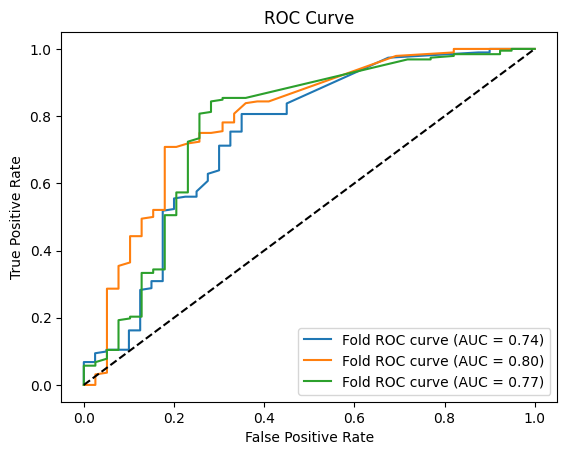

Average precision for class 0: 0.4329
Average precision for class 1: 0.9124
Weighted average precision: 0.8307
Average recall for class 0: 0.6107
Average recall for class 1: 0.8347
Weighted average recall: 0.7965
Average F1-score for class 0: 0.5066
Average F1-score for class 1: 0.8718
Weighted average F1-score: 0.8096
Average ROC AUC score: 0.7695
Average Confusion Matrix:
[[ 24.          15.33333333]
 [ 31.66666667 160.        ]]


In [27]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import BorderlineSMOTE
import numpy as np
import matplotlib.pyplot as plt

# Apply Borderline-SMOTE to balance classes in the training set
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Define parameters for RandomizedSearch with additional regularization adjustments
param_dist_xgb = {
    'n_estimators': [400, 500],
    'max_depth': [6, 10],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1.5, 2],
    'gamma': [0.5, 1],
    'min_child_weight': [1, 5],
    'reg_alpha': [0.5, 1],
    'reg_lambda': [1, 1.5]
}

random_search_xgb = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='aucpr'),
    param_distributions=param_dist_xgb,
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    n_jobs=-1,
    n_iter=10
)

# Run Randomized Search
random_search_xgb.fit(X_train_resampled, y_train_resampled)
print(f"Best parameters for XGBoost: {random_search_xgb.best_params_}")

# Evaluate the optimized model with StratifiedKFold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
xgb_params = random_search_xgb.best_params_
xgb_params.update({'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'random_state': 42})

# Initialize lists to store metrics for each fold
precision_scores = {'0': [], '1': [], 'weighted': []}
recall_scores = {'0': [], '1': [], 'weighted': []}
f1_scores = {'0': [], '1': [], 'weighted': []}
confusion_matrices = []
roc_auc_scores = []

# Perform stratified cross-validation
for train_index, test_index in skf.split(X_train_scaled, y_train_array):
    X_fold_train, X_fold_val = X_train_scaled[train_index], X_train_scaled[test_index]
    y_fold_train, y_fold_val = y_train_array[train_index], y_train_array[test_index]

    X_fold_resampled, y_fold_resampled = smote.fit_resample(X_fold_train, y_fold_train)
    xgb_model = XGBClassifier(**xgb_params)
    xgb_model.fit(X_fold_resampled, y_fold_resampled, eval_set=[(X_fold_val, y_fold_val)], verbose=False)
    
    y_fold_pred = xgb_model.predict(X_fold_val)
    y_fold_probs = xgb_model.predict_proba(X_fold_val)[:, 1]
    
    # Calculate metrics
    report = classification_report(y_fold_val, y_fold_pred, output_dict=True)
    precision_scores['0'].append(report['0']['precision'])
    precision_scores['1'].append(report['1']['precision'])
    precision_scores['weighted'].append(report['weighted avg']['precision'])
    
    recall_scores['0'].append(report['0']['recall'])
    recall_scores['1'].append(report['1']['recall'])
    recall_scores['weighted'].append(report['weighted avg']['recall'])
    
    f1_scores['0'].append(report['0']['f1-score'])
    f1_scores['1'].append(report['1']['f1-score'])
    f1_scores['weighted'].append(report['weighted avg']['f1-score'])
    
    confusion_matrices.append(confusion_matrix(y_fold_val, y_fold_pred))
    
    # Calculate AUC-ROC for the current fold
    roc_auc = roc_auc_score(y_fold_val, y_fold_probs)
    roc_auc_scores.append(roc_auc)
    
    # Plot AUC-ROC curve
    fpr, tpr, _ = roc_curve(y_fold_val, y_fold_probs)
    plt.plot(fpr, tpr, label=f'Fold ROC curve (AUC = {roc_auc:.2f})')

# Show AUC-ROC plot
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Display averaged results across all folds
print(f"Average precision for class 0: {np.mean(precision_scores['0']):.4f}")
print(f"Average precision for class 1: {np.mean(precision_scores['1']):.4f}")
print(f"Weighted average precision: {np.mean(precision_scores['weighted']):.4f}")

print(f"Average recall for class 0: {np.mean(recall_scores['0']):.4f}")
print(f"Average recall for class 1: {np.mean(recall_scores['1']):.4f}")
print(f"Weighted average recall: {np.mean(recall_scores['weighted']):.4f}")

print(f"Average F1-score for class 0: {np.mean(f1_scores['0']):.4f}")
print(f"Average F1-score for class 1: {np.mean(f1_scores['1']):.4f}")
print(f"Weighted average F1-score: {np.mean(f1_scores['weighted']):.4f}")

print(f"Average ROC AUC score: {np.mean(roc_auc_scores):.4f}")

mean_confusion_matrix = np.mean(confusion_matrices, axis=0)
print("Average Confusion Matrix:")
print(mean_confusion_matrix)

In [28]:
# Filtrar perfiles sin empleo
unemployed_profiles_xgb = df[df['employed'] == 0].copy()  # Filtra los perfiles que no están actualmente empleados

# Seleccionar las características importantes utilizadas en el entrenamiento
unemployed_features_xgb = unemployed_profiles_xgb[features].fillna(0)

# Escalar las características de los perfiles sin empleo usando el mismo escalador
unemployed_features_scaled_xgb = scaler.transform(unemployed_features_xgb)

# Predecir probabilidades de empleo con el modelo optimizado de XGBoost
y_probs_unemployed_xgb = xgb_model.predict_proba(unemployed_features_scaled_xgb)[:, 1]

# Añadir las probabilidades predichas al DataFrame
unemployed_profiles_xgb['predicted_probability'] = y_probs_unemployed_xgb

# Aplicar un umbral final para considerar a alguien como candidato potencial (ajustar según sea necesario)
final_threshold = 0.4125  # Ajusta este umbral según el F1-Score óptimo obtenido

# Aplicar el umbral para considerar a alguien como candidato potencial
unemployed_profiles_xgb['predicted_employed'] = (y_probs_unemployed_xgb >= final_threshold).astype(int)

# Filtrar los perfiles que son candidatos potenciales
potential_candidates_xgb = unemployed_profiles_xgb[unemployed_profiles_xgb['predicted_employed'] == 1]

# Ordenar los candidatos potenciales de mayor a menor probabilidad de ser empleados
potential_candidates_xgb_sorted = potential_candidates_xgb.sort_values(by='predicted_probability', ascending=False)

# Guardar los candidatos potenciales ordenados en un archivo CSV
potential_candidates_xgb_sorted.to_csv('./../data/potential_candidates_xgboost_optimized.csv', index=False)

print("Candidatos potenciales ordenados guardados en './../data/potential_candidates_xgboost_optimized.csv'")

potential_candidates_xgb_sorted.head()

Candidatos potenciales ordenados guardados en './../data/potential_candidates_xgboost_optimized.csv'


,timestamp,id,name,city,country_code,region,current_company:company_id,current_company:name,position,following,...,сourses,employed,education_count,certifications_count,languages_count,volunteer_experience_count,courses_count,experience_years,predicted_probability,predicted_employed
63,2021-06-06,dave-marston-1b611a6,Dave Marston,"Bordentown, New Jersey, United States",US,EU,NaN,NaN,SEO Professional,282.0,...,NaN,0,2,3,0,0,0,10,0.993524,1
164,2022-03-11,ameen-zakariya-0383367a,Ameen Zakariya,Pakistan,PK,AS,NaN,NaN,"Accountant, Standard Tea Co.",53.0,...,NaN,0,1,1,3,0,0,48,0.989807,1
416,2023-04-16,nafeemahmed,Nafeem Ahmed,NaN,US,NaN,NaN,NaN,Student,NaN,...,NaN,0,2,7,2,3,0,5,0.988687,1
193,2022-12-18,thomyiawright,Thomyia Wright,"Greater Birmingham, Alabama Area",US,NaN,NaN,NaN,Professional Storyteller (Photographer) - Spec...,NaN,...,NaN,0,2,1,0,0,0,12,0.986388,1
210,2023-01-13,lina-del-mundo-aa57317b,Lina del Mundo,"Chantilly, Virginia, United States",US,NaN,NaN,NaN,General Ledger and Financial Reporting at AIAA,NaN,...,NaN,0,1,0,2,0,0,42,0.983941,1


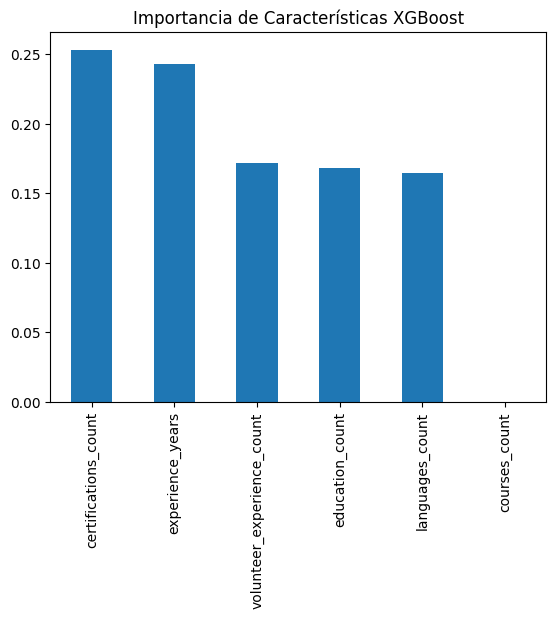

Importancias de características guardadas en './data/feature_importances_xgboost.csv'


In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Entrenar el modelo XGBoost optimizado con los datos resampleados (por si aún no está entrenado)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Extraer la importancia de las características usando el modelo XGBoost optimizado
feature_importances_xgb = pd.Series(xgb_model.feature_importances_, index=features)

# Ordenar las importancias en orden descendente
feature_importances_xgb_sorted = feature_importances_xgb.sort_values(ascending=False)

# Visualizar las importancias
feature_importances_xgb_sorted.plot(kind='bar', title='Importancia de Características XGBoost')
plt.show()

# Guardar las importancias en un archivo CSV para usar en la aplicación Streamlit
feature_importances_xgb_df = pd.DataFrame({
    'feature': feature_importances_xgb_sorted.index,
    'importance': feature_importances_xgb_sorted.values
})

# Guarda el DataFrame de importancias en un CSV
feature_importances_xgb_df.to_csv('./../data/feature_importances_xgboost.csv', index=False)

print("Importancias de características guardadas en './data/feature_importances_xgboost.csv'")

# Seleccionar las características más importantes (por encima de un umbral, por ejemplo 0.05)
important_features_xgb = feature_importances_xgb[feature_importances_xgb > 0.05].index.tolist()
X_train_important_xgb = X_train[important_features_xgb]
X_test_important_xgb = X_test[important_features_xgb]

4.1 Entrenamiento y evaluación de modelos (Random Forest)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\pascu\Desktop\MÁSTER INTELIGENCIA ARTIFICIAL\TFM\Talent-Analyzer-AI\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for Random Forest: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


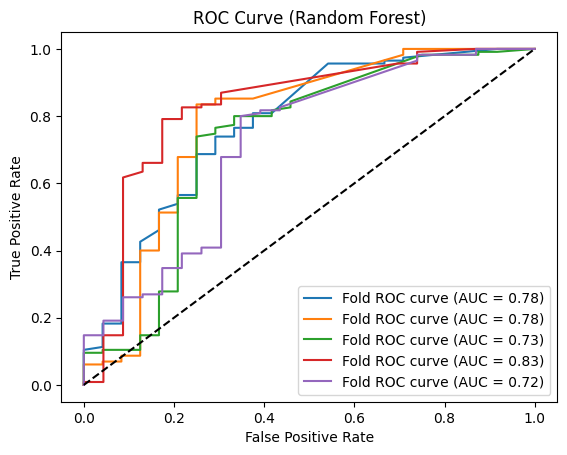

Average precision for class 0 (Random Forest): 0.4228
Average precision for class 1 (Random Forest): 0.9243
Weighted average precision (Random Forest): 0.8389
Average recall for class 0 (Random Forest): 0.6779
Average recall for class 1 (Random Forest): 0.8087
Weighted average recall (Random Forest): 0.7864
Average F1-score for class 0 (Random Forest): 0.5205
Average F1-score for class 1 (Random Forest): 0.8626
Weighted average F1-score (Random Forest): 0.8043
Average ROC AUC score (Random Forest): 0.7665
Average Confusion Matrix (Random Forest):
[[16.   7.6]
 [22.  93. ]]


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt

# Apply SMOTE to balance classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Set up parameters for Random Forest GridSearch
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Configure GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='f1_weighted',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Execute Grid Search
grid_search_rf.fit(X_train_resampled, y_train_resampled)
print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")

# Create the Random Forest model with the best hyperparameters
best_params_rf = grid_search_rf.best_params_
rf_model = RandomForestClassifier(**best_params_rf, random_state=42)

# Evaluate the optimized model with StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
precision_scores_rf = {'0': [], '1': [], 'weighted': []}
recall_scores_rf = {'0': [], '1': [], 'weighted': []}
f1_scores_rf = {'0': [], '1': [], 'weighted': []}
confusion_matrices_rf = []
roc_auc_scores_rf = []

# Perform stratified cross-validation
for train_index, test_index in skf.split(X_train_scaled, y_train_array):
    # Split data into training and validation sets for each fold
    X_fold_train, X_fold_val = X_train_scaled[train_index], X_train_scaled[test_index]
    y_fold_train, y_fold_val = y_train_array[train_index], y_train_array[test_index]

    # Apply SMOTE on each fold to balance classes
    X_fold_resampled, y_fold_resampled = smote.fit_resample(X_fold_train, y_fold_train)

    # Train the model on the current fold
    rf_model.fit(X_fold_resampled, y_fold_resampled)
    y_fold_pred = rf_model.predict(X_fold_val)
    y_fold_probs = rf_model.predict_proba(X_fold_val)[:, 1]  # Probabilities for the positive class

    # Calculate performance metrics
    report = classification_report(y_fold_val, y_fold_pred, output_dict=True)
    
    # Save metrics for each class and weighted average
    precision_scores_rf['0'].append(report['0']['precision'])
    precision_scores_rf['1'].append(report['1']['precision'])
    precision_scores_rf['weighted'].append(report['weighted avg']['precision'])
    
    recall_scores_rf['0'].append(report['0']['recall'])
    recall_scores_rf['1'].append(report['1']['recall'])
    recall_scores_rf['weighted'].append(report['weighted avg']['recall'])
    
    f1_scores_rf['0'].append(report['0']['f1-score'])
    f1_scores_rf['1'].append(report['1']['f1-score'])
    f1_scores_rf['weighted'].append(report['weighted avg']['f1-score'])
    
    confusion_matrices_rf.append(confusion_matrix(y_fold_val, y_fold_pred))
    
    # Calculate AUC-ROC for the current fold
    roc_auc = roc_auc_score(y_fold_val, y_fold_probs)
    roc_auc_scores_rf.append(roc_auc)
    
    # Plot AUC-ROC curve
    fpr, tpr, _ = roc_curve(y_fold_val, y_fold_probs)
    plt.plot(fpr, tpr, label=f'Fold ROC curve (AUC = {roc_auc:.2f})')

# Show AUC-ROC plot
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest)')
plt.legend(loc='best')
plt.show()

# Display averaged results across all folds
print(f"Average precision for class 0 (Random Forest): {np.mean(precision_scores_rf['0']):.4f}")
print(f"Average precision for class 1 (Random Forest): {np.mean(precision_scores_rf['1']):.4f}")
print(f"Weighted average precision (Random Forest): {np.mean(precision_scores_rf['weighted']):.4f}")

print(f"Average recall for class 0 (Random Forest): {np.mean(recall_scores_rf['0']):.4f}")
print(f"Average recall for class 1 (Random Forest): {np.mean(recall_scores_rf['1']):.4f}")
print(f"Weighted average recall (Random Forest): {np.mean(recall_scores_rf['weighted']):.4f}")

print(f"Average F1-score for class 0 (Random Forest): {np.mean(f1_scores_rf['0']):.4f}")
print(f"Average F1-score for class 1 (Random Forest): {np.mean(f1_scores_rf['1']):.4f}")
print(f"Weighted average F1-score (Random Forest): {np.mean(f1_scores_rf['weighted']):.4f}")

print(f"Average ROC AUC score (Random Forest): {np.mean(roc_auc_scores_rf):.4f}")

# Show the averaged confusion matrix
mean_confusion_matrix_rf = np.mean(confusion_matrices_rf, axis=0)
print("Average Confusion Matrix (Random Forest):")
print(mean_confusion_matrix_rf)

5. Predicción de Candidatos Potenciales (Random Forest)

In [31]:
# Filtrar perfiles sin empleo
unemployed_profiles_rf = df[df['employed'] == 0].copy()  # Filtra los perfiles que no están actualmente empleados

# Seleccionar las características importantes utilizadas en el entrenamiento
unemployed_features_rf = unemployed_profiles_rf[features].fillna(0)

# Escalar las características de los perfiles sin empleo usando el mismo escalador
unemployed_features_scaled_rf = scaler.transform(unemployed_features_rf)

# Predecir probabilidades de empleo con el modelo Random Forest
y_probs_unemployed_rf = rf_model.predict_proba(unemployed_features_scaled_rf)[:, 1]

# Añadir las probabilidades predichas al DataFrame
unemployed_profiles_rf['predicted_probability'] = y_probs_unemployed_rf

# Aplicar un umbral final para considerar a alguien como candidato potencial (puedes ajustar según sea necesario)
final_threshold = 0.5  # Ajusta este umbral si es necesario

# Aplicar el umbral para considerar a alguien como candidato potencial
unemployed_profiles_rf['predicted_employed'] = (y_probs_unemployed_rf >= final_threshold).astype(int)

# Filtrar los perfiles que son candidatos potenciales
potential_candidates_rf = unemployed_profiles_rf[unemployed_profiles_rf['predicted_employed'] == 1]

# Ordenar los candidatos potenciales de mayor a menor probabilidad de ser empleados
potential_candidates_rf_sorted = potential_candidates_rf.sort_values(by='predicted_probability', ascending=False)

# Guardar los candidatos potenciales ordenados en un archivo CSV
potential_candidates_rf_sorted.to_csv('./../data/potential_candidates_random_forest.csv', index=False)

print("Candidatos potenciales ordenados guardados en 'potential_candidates_random_forest.csv'")

potential_candidates_rf_sorted.head()

Candidatos potenciales ordenados guardados en 'potential_candidates_random_forest.csv'


,timestamp,id,name,city,country_code,region,current_company:company_id,current_company:name,position,following,...,сourses,employed,education_count,certifications_count,languages_count,volunteer_experience_count,courses_count,experience_years,predicted_probability,predicted_employed
63,2021-06-06,dave-marston-1b611a6,Dave Marston,"Bordentown, New Jersey, United States",US,EU,NaN,NaN,SEO Professional,282.0,...,NaN,0,2,3,0,0,0,10,0.970593,1
390,2021-05-01,heena-patel-b9816118b,Heena Patel,San Francisco Bay Area,US,NaN,NaN,NaN,Staff Accountant at Quark Pharmaceuticals,28.0,...,NaN,0,1,0,0,0,0,15,0.966610,1
564,2023-03-01,krystyna-paul-086763a5,Krystyna Paul,Greater Perth Area,AU,OC,NaN,NaN,Mining & Metals Professional,NaN,...,NaN,0,0,0,0,0,0,9,0.963401,1
382,2023-01-06,donnie-norton-56428598,Donnie Norton,"Louisville, Kentucky, United States",US,NaN,NaN,NaN,Owner One Source Construction,NaN,...,NaN,0,0,0,0,0,0,22,0.956288,1
416,2023-04-16,nafeemahmed,Nafeem Ahmed,NaN,US,NaN,NaN,NaN,Student,NaN,...,NaN,0,2,7,2,3,0,5,0.946491,1


Optimización y mejora de Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

# Define parameters for RandomizedSearchCV for Random Forest
param_dist_rf = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),  # Limit the max depth
    'min_samples_split': randint(5, 20),  # Increase for regularization
    'min_samples_leaf': randint(2, 10),  # Increase for regularization
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Configure RandomizedSearchCV for Random Forest
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=100,                   # Number of parameter combinations to try
    scoring='f1_weighted',        # Evaluation metric
    cv=5,                         # 5-fold cross-validation
    verbose=2,                    # Verbose output level
    random_state=42,
    n_jobs=-1                     # Use all available cores
)

# Apply SMOTE to balance classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Execute Randomized Search with resampled data
random_search_rf.fit(X_train_resampled, y_train_resampled)
print(f"Best parameters after Randomized Search: {random_search_rf.best_params_}")

# Create the Random Forest model with the best hyperparameters found
optimized_rf_model = RandomForestClassifier(
    **random_search_rf.best_params_,
    class_weight={0: 1.5, 1: 1},  # Assign more weight to class 0
    random_state=42
)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters after Randomized Search: {'bootstrap': False, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 275}


Mean AUC-ROC Score across folds: 0.7724


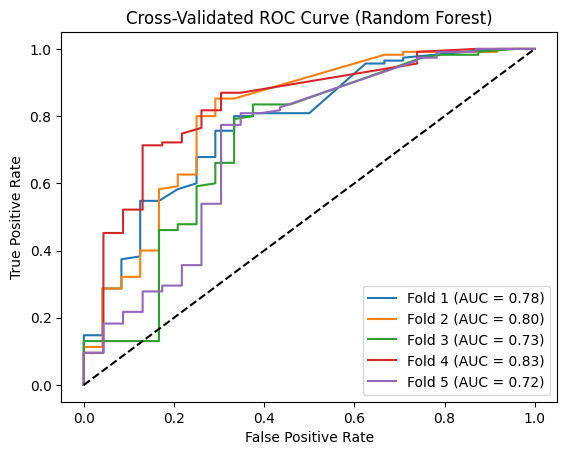

Optimal threshold based on F1-Score: 0.07767931908887708
Classification Report with Optimal Threshold:
               precision    recall  f1-score   support

           0       0.86      0.38      0.53        47
           1       0.89      0.99      0.94       250

    accuracy                           0.89       297
   macro avg       0.88      0.69      0.73       297
weighted avg       0.89      0.89      0.87       297



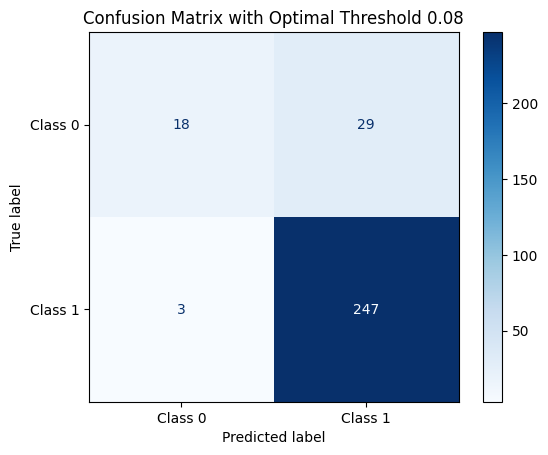

In [46]:
# Convert y_train to a numpy array to avoid indexing issues
y_train_array = np.array(y_train)

# StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store AUC-ROC scores for each fold
roc_auc_scores = []
fpr_list = []
tpr_list = []

# Perform cross-validation
for train_index, test_index in skf.split(X_train_scaled, y_train_array):
    # Split the data into training and validation sets for the current fold
    X_fold_train, X_fold_val = X_train_scaled[train_index], X_train_scaled[test_index]
    y_fold_train, y_fold_val = y_train_array[train_index], y_train_array[test_index]

    # Apply SMOTE to the training fold
    X_fold_resampled, y_fold_resampled = SMOTE(random_state=42).fit_resample(X_fold_train, y_fold_train)

    # Train the optimized Random Forest model on the resampled data
    optimized_rf_model.fit(X_fold_resampled, y_fold_resampled)
    
    # Predict probabilities on the validation set
    y_fold_probs = optimized_rf_model.predict_proba(X_fold_val)[:, 1]

    # Calculate AUC-ROC for the current fold
    roc_auc = roc_auc_score(y_fold_val, y_fold_probs)
    roc_auc_scores.append(roc_auc)
    
    # Calculate the false positive rate and true positive rate for ROC curve
    fpr, tpr, _ = roc_curve(y_fold_val, y_fold_probs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

# Calculate and print the mean AUC-ROC score
mean_roc_auc = np.mean(roc_auc_scores)
print(f"Mean AUC-ROC Score across folds: {mean_roc_auc:.4f}")

# Plot AUC-ROC curves for each fold
plt.figure()
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], label=f'Fold {i+1} (AUC = {roc_auc_scores[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cross-Validated ROC Curve (Random Forest)')
plt.legend(loc='best')
plt.show()

# Final fit on full resampled data for potential final evaluation or deployment
optimized_rf_model.fit(X_train_resampled, y_train_resampled)

# Predict probabilities on the test set (if needed for deployment evaluation)
y_probs = optimized_rf_model.predict_proba(X_test_scaled)[:, 1]

# Calculate the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Calculate F1-Score in a more robust way
f1_scores = np.where(precision + recall > 0, 2 * (precision * recall) / (precision + recall), 0)

# Find the optimal threshold to maximize F1-Score
optimal_threshold = thresholds[f1_scores.argmax()]
print(f"Optimal threshold based on F1-Score: {optimal_threshold}")

# Apply the optimal threshold
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)

# Classification report with the optimal threshold
print("Classification Report with Optimal Threshold:\n", classification_report(y_test, y_pred_optimal))

# Confusion matrix with the optimal threshold
cm = confusion_matrix(y_test, y_pred_optimal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix with Optimal Threshold {optimal_threshold:.2f}")
plt.show()

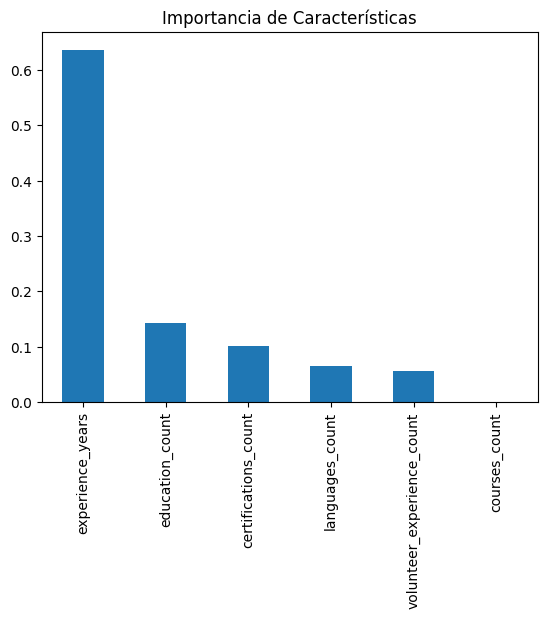

Importancias de características guardadas en './data/feature_importances_random_forest.csv'


In [34]:
# Entrenar el modelo de Random Forest optimizado para calcular la importancia de las características con datos resampleados
optimized_rf_model.fit(X_train_resampled, y_train_resampled)

# Extraer la importancia de las características
feature_importances = pd.Series(optimized_rf_model.feature_importances_, index=features)

# Ordenar las importancias en orden descendente
feature_importances_sorted = feature_importances.sort_values(ascending=False)

# Visualizar las importancias
feature_importances_sorted.plot(kind='bar', title='Importancia de Características')
plt.show()

# Guardar las importancias en un archivo CSV para usar en la aplicación Streamlit
feature_importances_df = pd.DataFrame({
    'feature': feature_importances_sorted.index,
    'importance': feature_importances_sorted.values
})

# Guarda el DataFrame de importancias en un CSV
feature_importances_df.to_csv('./../data/feature_importances_random_forest.csv', index=False)

print("Importancias de características guardadas en './data/feature_importances_random_forest.csv'")

# Seleccionar las características más importantes (por encima de un umbral)
important_features = feature_importances[feature_importances > 0.05].index.tolist()
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

Predicción de candidatos potenciales con random forest optimizado

In [35]:
# Filtrar perfiles sin empleo
unemployed_profiles_optimized = df[df['employed'] == 0].copy()  # Filtra los perfiles que no están actualmente empleados

# Seleccionar las características importantes utilizadas en el entrenamiento
unemployed_features_optimized = unemployed_profiles_optimized[features].fillna(0)

# Escalar las características de los perfiles sin empleo usando el mismo escalador
unemployed_features_scaled_optimized = scaler.transform(unemployed_features_optimized)

# Predecir probabilidades de empleo con el modelo optimizado de Random Forest
y_probs_unemployed_optimized = optimized_rf_model.predict_proba(unemployed_features_scaled_optimized)[:, 1]

final_threshold = 0.4125  # Ajusta este umbral según el F1-Score óptimo obtenido

# Añadir las probabilidades predichas al DataFrame
unemployed_profiles_optimized['predicted_probability'] = y_probs_unemployed_optimized

# Aplicar el umbral final para considerar a alguien como candidato potencial
unemployed_profiles_optimized['predicted_employed'] = (y_probs_unemployed_optimized >= final_threshold).astype(int)

# Filtrar los perfiles que son candidatos potenciales
potential_candidates_optimized_rf = unemployed_profiles_optimized[unemployed_profiles_optimized['predicted_employed'] == 1]

# Ordenar los candidatos potenciales de mayor a menor probabilidad de ser empleados
potential_candidates_optimized_rf_sorted = potential_candidates_optimized_rf.sort_values(by='predicted_probability', ascending=False)

# Guardar los candidatos potenciales ordenados en un archivo CSV
potential_candidates_optimized_rf_sorted.to_csv('./../data/potential_candidates_optimized_rf.csv', index=False)

print("Candidatos potenciales ordenados guardados en './data/potential_candidates_optimized_rf.csv'")

potential_candidates_optimized_rf_sorted.head()

Candidatos potenciales ordenados guardados en './data/potential_candidates_optimized_rf.csv'


,timestamp,id,name,city,country_code,region,current_company:company_id,current_company:name,position,following,...,сourses,employed,education_count,certifications_count,languages_count,volunteer_experience_count,courses_count,experience_years,predicted_probability,predicted_employed
63,2021-06-06,dave-marston-1b611a6,Dave Marston,"Bordentown, New Jersey, United States",US,EU,NaN,NaN,SEO Professional,282.0,...,NaN,0,2,3,0,0,0,10,0.959062,1
314,2022-04-10,mahesh-babu-n-7a79a474,MAHESH BABU N.,"Guntur, Andhra Pradesh, India",IN,AS,NaN,NaN,CA Finalist at The ICAI,135.0,...,NaN,0,3,1,4,0,0,5,0.943236,1
375,2023-01-03,liam-buckley-45694b63,Liam Buckley,"North Weald Bassett, England, United Kingdom",GB,EU,NaN,NaN,.,NaN,...,NaN,0,3,0,0,0,0,16,0.868251,1
955,2023-03-22,ibrahimkabil,Ibrahim Kabil,NaN,MX,NaN,NaN,NaN,Creative Director & Digital Media Producer,NaN,...,NaN,0,2,0,1,0,0,17,0.788836,1
338,2022-12-21,john-stark-5603534,John Stark,"Ann Arbor, Michigan, United States",US,NaN,NaN,NaN,...,NaN,...,NaN,0,2,0,1,0,0,17,0.788836,1


Opcional: Optimización con ensemble stacking

[LightGBM] [Info] Number of positive: 460, number of negative: 460
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 920, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400000 -> initscore=-0.405465
[LightGBM] [Info] Start training from score -0.405465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


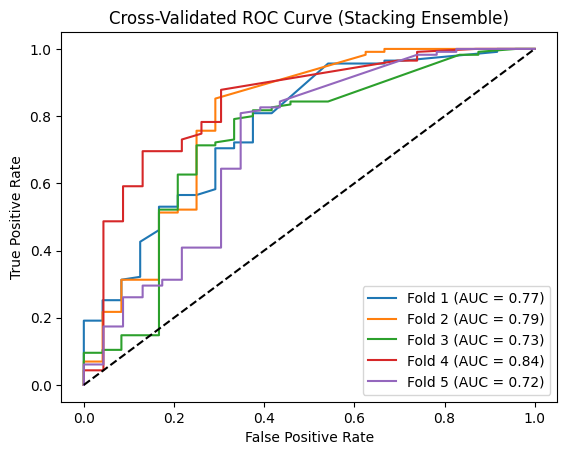

[LightGBM] [Info] Number of positive: 575, number of negative: 575
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 1150, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400000 -> initscore=-0.405465
[LightGBM] [Info] Start training from score -0.405465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

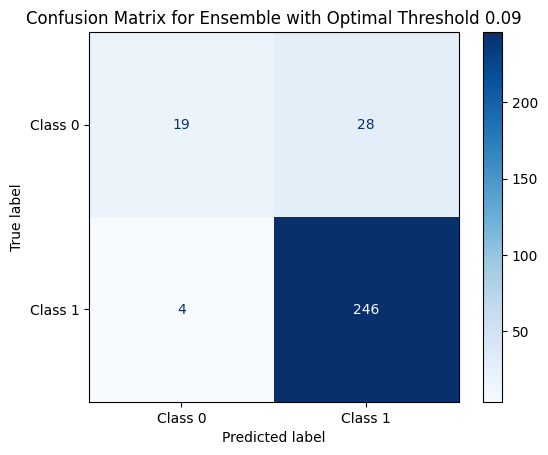

In [52]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt

# Define SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Define an ensemble stacking with three optimized models and moderate class_weight adjustment
estimators = [
    ('rf', RandomForestClassifier(**random_search_rf.best_params_, class_weight={0: 1.5, 1: 1}, random_state=42)),
    ('xgb', XGBClassifier(**grid_search_xgb.best_params_)),
    ('lgbm', LGBMClassifier(class_weight={0: 1.5, 1: 1}, random_state=42))
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5,
)

# Convert y_train to a numpy array to avoid indexing issues
y_train_array = np.array(y_train)

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store ROC AUC scores for each fold
roc_auc_scores = []
fpr_list = []
tpr_list = []

# Perform cross-validation
for train_index, test_index in skf.split(X_train_scaled, y_train_array):
    # Split the data into training and validation sets for the current fold
    X_fold_train, X_fold_val = X_train_scaled[train_index], X_train_scaled[test_index]
    y_fold_train, y_fold_val = y_train_array[train_index], y_train_array[test_index]

    # Apply SMOTE to the training fold
    X_fold_resampled, y_fold_resampled = SMOTE(random_state=42).fit_resample(X_fold_train, y_fold_train)

    # Train the stacking model on the resampled data
    stacking_model.fit(X_fold_resampled, y_fold_resampled)
    
    # Predict probabilities on the validation set
    y_fold_probs = stacking_model.predict_proba(X_fold_val)[:, 1]

    # Calculate AUC-ROC for the current fold
    roc_auc = roc_auc_score(y_fold_val, y_fold_probs)
    roc_auc_scores.append(roc_auc)
    
    # Calculate the false positive rate and true positive rate for ROC curve
    fpr, tpr, _ = roc_curve(y_fold_val, y_fold_probs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

# Calculate and print the mean AUC-ROC score
mean_roc_auc = np.mean(roc_auc_scores)
print(f"Mean AUC-ROC Score across folds: {mean_roc_auc:.4f}")

# Plot AUC-ROC curves for each fold
plt.figure()
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], label=f'Fold {i+1} (AUC = {roc_auc_scores[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cross-Validated ROC Curve (Stacking Ensemble)')
plt.legend(loc='best')
plt.show()

# Final fit on full resampled data for potential final evaluation or deployment
stacking_model.fit(X_train_resampled, y_train_resampled)

# Predict probabilities on the test set (if needed for final evaluation)
y_probs_stacking = stacking_model.predict_proba(X_test_scaled)[:, 1]

# Calculate the precision-recall curve to find the optimal threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_probs_stacking)

# Calculate F1-Score in a more robust way
f1_scores = np.where(precision + recall > 0, 2 * (precision * recall) / (precision + recall), 0)

# Find the optimal threshold to maximize the F1-Score
optimal_threshold = thresholds[f1_scores.argmax()]
print(f"Optimal threshold based on the F1-Score for the ensemble: {optimal_threshold}")

# Use the optimal threshold to make predictions
y_pred_optimal = (y_probs_stacking >= optimal_threshold).astype(int)

# Classification report and confusion matrix with the optimal threshold
report = classification_report(y_test, y_pred_optimal, target_names=['Class 0', 'Class 1'], digits=4)
print(f"Classification Report with optimal threshold {optimal_threshold:.2f}:\n", report)

# Display the confusion matrix with the optimal threshold
cm = confusion_matrix(y_test, y_pred_optimal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for Ensemble with Optimal Threshold {optimal_threshold:.2f}")
plt.show()

Predicción de potenciales candidatos con el modelo ensemble optimizado

In [50]:
from sklearn.preprocessing import StandardScaler

# Asegúrate de usar todas las características que el modelo espera (todas las usadas en el entrenamiento)
all_features = features  # Verifica que 'features' sea el conjunto usado para entrenar

# Filtrar perfiles sin empleo
unemployed_profiles = df[df['employed'] == 0].copy()  # Filtra los perfiles que no están actualmente empleados

# Seleccionar todas las características utilizadas en el entrenamiento
unemployed_features = unemployed_profiles[all_features].fillna(0)

# Reajustar el escalador con las características correctas, si el problema persiste
scaler = StandardScaler()
scaler.fit(X_train[all_features])  # Ajustar el escalador con el conjunto de entrenamiento

# Escalar las características de los perfiles sin empleo usando el mismo escalador
unemployed_features_scaled = scaler.transform(unemployed_features)

# Predecir las probabilidades de los perfiles sin empleo usando el ensemble stacking model
y_probs_unemployed = stacking_model.predict_proba(unemployed_features_scaled)[:, 1]

# Añadir las probabilidades al dataframe
unemployed_profiles['predicted_probability'] = y_probs_unemployed

# Filtrar los perfiles que son candidatos potenciales aplicando el umbral y ordenarlos por probabilidad
potential_candidates_optimized = unemployed_profiles[unemployed_profiles['predicted_probability'] >= final_threshold]

# Ordenar los candidatos potenciales por probabilidad de mayor a menor
potential_candidates_optimized = potential_candidates_optimized.sort_values(by='predicted_probability', ascending=False)

# Guardar los candidatos potenciales en un archivo CSV
try:
    potential_candidates_optimized.to_csv('./../data/potential_candidates_optimized_ensemble.csv', index=False)
    print("Candidatos potenciales guardados en './../data/potential_candidates_optimized_ensemble.csv'")
except Exception as e:
    print("Error al guardar el archivo CSV:", e)
    raise

# Mostrar los primeros candidatos ordenados
potential_candidates_optimized.head()

Candidatos potenciales guardados en './../data/potential_candidates_optimized_ensemble.csv'


,timestamp,id,name,city,country_code,region,current_company:company_id,current_company:name,position,following,...,volunteer_experience,сourses,employed,education_count,certifications_count,languages_count,volunteer_experience_count,courses_count,experience_years,predicted_probability
63,2021-06-06,dave-marston-1b611a6,Dave Marston,"Bordentown, New Jersey, United States",US,EU,NaN,NaN,SEO Professional,282.0,...,NaN,NaN,0,2,3,0,0,0,10,0.948865
314,2022-04-10,mahesh-babu-n-7a79a474,MAHESH BABU N.,"Guntur, Andhra Pradesh, India",IN,AS,NaN,NaN,CA Finalist at The ICAI,135.0,...,NaN,NaN,0,3,1,4,0,0,5,0.948638
375,2023-01-03,liam-buckley-45694b63,Liam Buckley,"North Weald Bassett, England, United Kingdom",GB,EU,NaN,NaN,.,NaN,...,NaN,NaN,0,3,0,0,0,0,16,0.932697
955,2023-03-22,ibrahimkabil,Ibrahim Kabil,NaN,MX,NaN,NaN,NaN,Creative Director & Digital Media Producer,NaN,...,NaN,NaN,0,2,0,1,0,0,17,0.929459
338,2022-12-21,john-stark-5603534,John Stark,"Ann Arbor, Michigan, United States",US,NaN,NaN,NaN,...,NaN,...,NaN,NaN,0,2,0,1,0,0,17,0.929459


Implementación con SMOTE-Tomek y Gradient Boosting:

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Mean AUC-ROC Score across folds: 0.7750


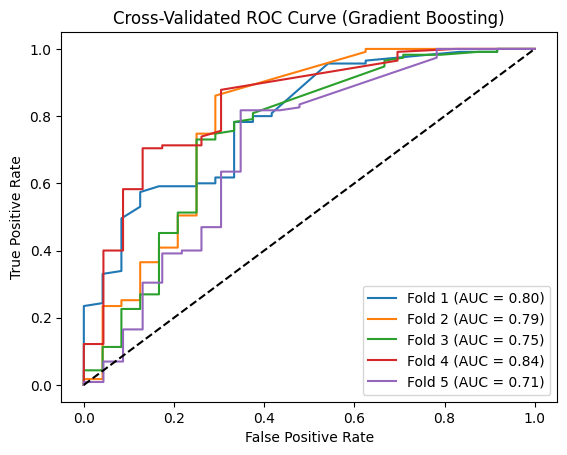

Optimal threshold based on F1-Score for Gradient Boosting: 0.09937083673116824
Classification Report Gradient Boosting with optimal threshold 0.10:
               precision    recall  f1-score   support

     Class 0     0.8000    0.4255    0.5556        47
     Class 1     0.9007    0.9800    0.9387       250

    accuracy                         0.8923       297
   macro avg     0.8504    0.7028    0.7471       297
weighted avg     0.8848    0.8923    0.8781       297



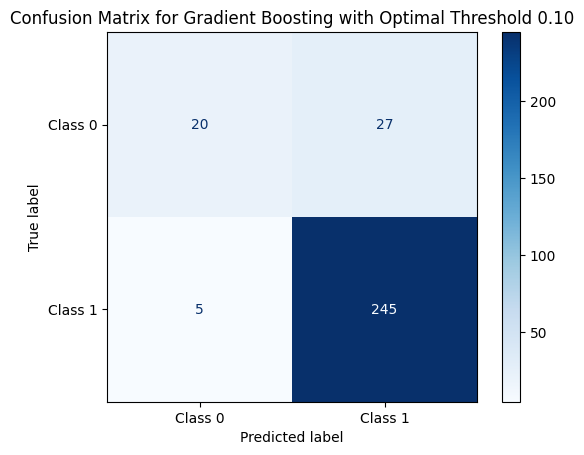

In [60]:
from imblearn.combine import SMOTETomek
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

# Convert y_train to numpy array for indexing
y_train_array = np.array(y_train)

# Apply SMOTE-Tomek to balance the classes in the training set
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_scaled, y_train_array)

# Set up parameters for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0]
}

# Configure GridSearchCV to find the best parameters
grid_search_gb = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid_gb,
    scoring='f1_weighted',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Execute Grid Search to find the best parameters
grid_search_gb.fit(X_train_resampled, y_train_resampled)
print(f"Best parameters for Gradient Boosting: {grid_search_gb.best_params_}")

# Train the Gradient Boosting model with the best hyperparameters
gb_model = GradientBoostingClassifier(**grid_search_gb.best_params_, random_state=42)

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store AUC-ROC scores for each fold
roc_auc_scores = []
fpr_list = []
tpr_list = []

# Perform cross-validation
for train_index, test_index in skf.split(X_train_scaled, y_train_array):
    # Split the data into training and validation sets for the current fold
    X_fold_train, X_fold_val = X_train_scaled[train_index], X_train_scaled[test_index]
    y_fold_train, y_fold_val = y_train_array[train_index], y_train_array[test_index]

    # Apply SMOTE-Tomek to the training fold
    X_fold_resampled, y_fold_resampled = smote_tomek.fit_resample(X_fold_train, y_fold_train)

    # Train the model on the resampled data
    gb_model.fit(X_fold_resampled, y_fold_resampled)

    # Predict probabilities on the validation set
    y_fold_probs = gb_model.predict_proba(X_fold_val)[:, 1]

    # Calculate AUC-ROC for the current fold
    roc_auc = roc_auc_score(y_fold_val, y_fold_probs)
    roc_auc_scores.append(roc_auc)

    # Calculate the false positive rate and true positive rate for ROC curve
    fpr, tpr, _ = roc_curve(y_fold_val, y_fold_probs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

# Calculate and print the mean AUC-ROC score
mean_roc_auc = np.mean(roc_auc_scores)
print(f"Mean AUC-ROC Score across folds: {mean_roc_auc:.4f}")

# Plot AUC-ROC curves for each fold
plt.figure()
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], label=f'Fold {i+1} (AUC = {roc_auc_scores[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cross-Validated ROC Curve (Gradient Boosting)')
plt.legend(loc='best')
plt.show()

# Final fit on full resampled data for potential final evaluation or deployment
gb_model.fit(X_train_resampled, y_train_resampled)

# Predict probabilities on the test set (if needed for final evaluation)
y_probs_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

# Calculate the precision-recall curve to find the optimal threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_probs_gb)

# Calculate F1-Score to determine the optimal threshold
f1_scores = np.where(precision + recall > 0, 2 * (precision * recall) / (precision + recall), 0)
optimal_threshold = thresholds[f1_scores.argmax()]
print(f"Optimal threshold based on F1-Score for Gradient Boosting: {optimal_threshold}")

# Use the optimal threshold to make predictions
y_pred_optimal = (y_probs_gb >= optimal_threshold).astype(int)

# Classification report and confusion matrix with the optimal threshold
report = classification_report(y_test, y_pred_optimal, target_names=['Class 0', 'Class 1'], digits=4)
print(f"Classification Report Gradient Boosting with optimal threshold {optimal_threshold:.2f}:\n", report)

# Display the confusion matrix with the optimal threshold
cm = confusion_matrix(y_test, y_pred_optimal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for Gradient Boosting with Optimal Threshold {optimal_threshold:.2f}")
plt.show()

Predicción potenciales candidatos SMOTE-Tomek y Gradient Boosting:

In [61]:
# Filtrar perfiles sin empleo
unemployed_profiles = df[df['employed'] == 0].copy()
unemployed_features = unemployed_profiles[features].fillna(0)
unemployed_features_scaled = scaler.transform(unemployed_features)

# Predecir probabilidades con el modelo Gradient Boosting optimizado
unemployed_profiles['predicted_probability'] = gb_model.predict_proba(unemployed_features_scaled)[:, 1]

# Filtrar perfiles que son candidatos potenciales usando el umbral óptimo
potential_candidates = unemployed_profiles[unemployed_profiles['predicted_probability'] >= optimal_threshold]

# Ordenar los candidatos potenciales de mayor a menor probabilidad
potential_candidates_sorted = potential_candidates.sort_values(by='predicted_probability', ascending=False)

# Guardar los candidatos potenciales ordenados en un archivo CSV
potential_candidates_sorted.to_csv('./../data/potential_candidates_gradient_boosting.csv', index=False)
print("Candidatos potenciales guardados en 'potential_candidates_gradient_boosting.csv'")

potential_candidates_sorted.head()

Candidatos potenciales guardados en 'potential_candidates_gradient_boosting.csv'


,timestamp,id,name,city,country_code,region,current_company:company_id,current_company:name,position,following,...,volunteer_experience,сourses,employed,education_count,certifications_count,languages_count,volunteer_experience_count,courses_count,experience_years,predicted_probability
861,2023-01-24,thomas-houston-87a839147,Thomas Houston,"Illinois, United States",US,NaN,NaN,NaN,Looking for opportunities,NaN,...,"[{""cause"":""Poverty Alleviation"",""duration"":""No...",NaN,0,4,0,0,1,0,8,0.993344
314,2022-04-10,mahesh-babu-n-7a79a474,MAHESH BABU N.,"Guntur, Andhra Pradesh, India",IN,AS,NaN,NaN,CA Finalist at The ICAI,135.0,...,NaN,NaN,0,3,1,4,0,0,5,0.992708
63,2021-06-06,dave-marston-1b611a6,Dave Marston,"Bordentown, New Jersey, United States",US,EU,NaN,NaN,SEO Professional,282.0,...,NaN,NaN,0,2,3,0,0,0,10,0.990367
164,2022-03-11,ameen-zakariya-0383367a,Ameen Zakariya,Pakistan,PK,AS,NaN,NaN,"Accountant, Standard Tea Co.",53.0,...,NaN,NaN,0,1,1,3,0,0,48,0.960762
375,2023-01-03,liam-buckley-45694b63,Liam Buckley,"North Weald Bassett, England, United Kingdom",GB,EU,NaN,NaN,.,NaN,...,NaN,NaN,0,3,0,0,0,0,16,0.946641
